# Bagging

모형 결합에서 독립적인 Model의 수가 많으면 많을 수록 성능이 향상될 가능성이 높아진다. 하지만 Voting 방법론의 경우 독립적인 개별 모델을 모두 정의하는 점에서 한계가 있기에 이에 대한 해결책으로 배깅(Bagging) 방법론을 이용한다.

배깅 방법론은 같은 모델을 사용하지만 서로 다른 데이터셋을 학습시켜 마치 다른 모델을 사용한 것과 같이 개별 모델이 다른 결과를 출력하게 하는 일종의 트릭이라고 볼 수 있다.



- Train Set을 선택하는 방법

    - 같은 데이터 중복 샘플링 X : Pasting
    
    - 같은 데이터 중복 샘플링 O : Bagging
    
    - 일부 독립변수를 선택 : Random Subspaces
    
    - 데이터 샘플과 독립변수 모두 일부 랜덤 샘플링 : Random Patches


성능 평가 시 모델 학습에 사용하지 않은 데이터를 사용하는 경우 OOB(Out-of-bag)데이터라 부른다.

# sklearn을 이용한 Bagging

`BaggingClassifier` 클래스 제공

- base_estimator : 기본 모델
- n_estimator : 모델 갯수, 디폴트 10
- bootstrap : 데이터 중복, 디폴트 True
- max_samples : 데이터 샘플 중 선택할 샘플의 수 혹은 비율, 디폴트 1.0
- bootstrap_features : 특징 차원의 중복 사용 여부, 디폴트 False
- max_features : 다차원 독립변수 중 선택할 차원의 수 혹은 비율, 디폴트 1.0

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

# IRIS 데이터 준비
iris = load_iris()
X, y = iris.data[:, [0, 2]], iris.target

# 모델 생성
model1 = DecisionTreeClassifier(max_depth=10, random_state=0)
model2 = BaggingClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=100, random_state=0)

# 모델 학습
model1.fit(X, y)
model2.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                  n_estimators=100, random_state=0)

위의 일반적인 DecisionTree 모델과 Bagging 방식의 DecisionTree 모델을 비교한 결과 아래와 같은 판별 경계선을 확인할 수 있다.

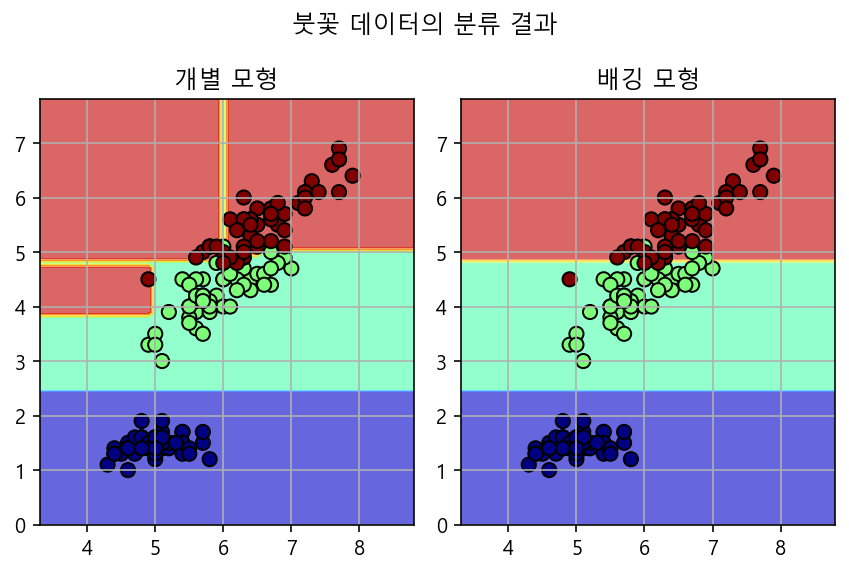

In [2]:
# 판별 경계선 비교

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
plt.subplot(121)
Z1 = model1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors="k")
plt.title("개별 모형")
plt.grid()
plt.subplot(122)
Z2 = model2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors="k")
plt.title("배깅 모형")
plt.suptitle("붓꽃 데이터의 분류 결과")
plt.tight_layout()
plt.grid()
plt.show()

개별 모형의 경우 Acc를 높이기 위해 max_depth를 10으로 지정했으며 판별 경계선 역시 직관적으로 과적합이 발생했음을 확인할 수 있다.

반면 배깅 모형의 경우 개별 모형은 max_depth가 2로 지정되어 Acc가 낮지만 이러한 Tree 모델을 100개 사용하는 것으로 보다 일반화된 판별 경계선이 생성된 것을 확인할 수 있다.

실제로 breast cancer 데이터를 이용해 일반적인 Decision Tree 모델과 배깅을 사용한 경우에 대해 교착검증을 실시한 결과 다음과 같이 배깅 모델에서 보다 높은 성능을 보이는 것을 확인할 수 있다.

In [31]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
X2 = bc.data
y2 = bc.target

model1 = DecisionTreeClassifier(max_depth=10)
model2 = BaggingClassifier(DecisionTreeClassifier(max_depth=2))

model1.fit(X2, y2)
model2.fit(X2, y2)

from sklearn.model_selection import cross_val_score

models = [model1, model2]
for model in models:
    results = cross_val_score(model, X2, y2, scoring='accuracy', cv=5)
    print(str(model).split('(')[0])
    print('교차검증 결과 :',results)
    print('교차검증 평균 ACC :',np.mean(results), '\n')

DecisionTreeClassifier
교차검증 결과 : [0.9122807  0.90350877 0.92105263 0.93859649 0.90265487]
교차검증 평균 ACC : 0.915618692749573 

BaggingClassifier
교차검증 결과 : [0.9122807  0.92105263 0.97368421 0.92982456 0.96460177]
교차검증 평균 ACC : 0.9402887750349324 



# RandomForest

위의 배깅방식에서 Decision Tree를 base estimator로 이용해 100개의 Decision Tree를 이용해 모델 학습을 진행했다.

이러한 여러개의 Decision Tree를 개별 모형으로 사용하는 모형 결합 방법은 Random Forest라는 Model로 불린다.

RandomForest는 Train set을 선택하는 방법으로 Subspaces를 사용한다.

그 이유는 Decisison Tree에서는 각 모델마다 하나의 데이터셋을 사용하는 것이 아닌 트리가 분리되는 각 노드마다 한 종류의 데이터를 사용할 수 있기 때문이다.

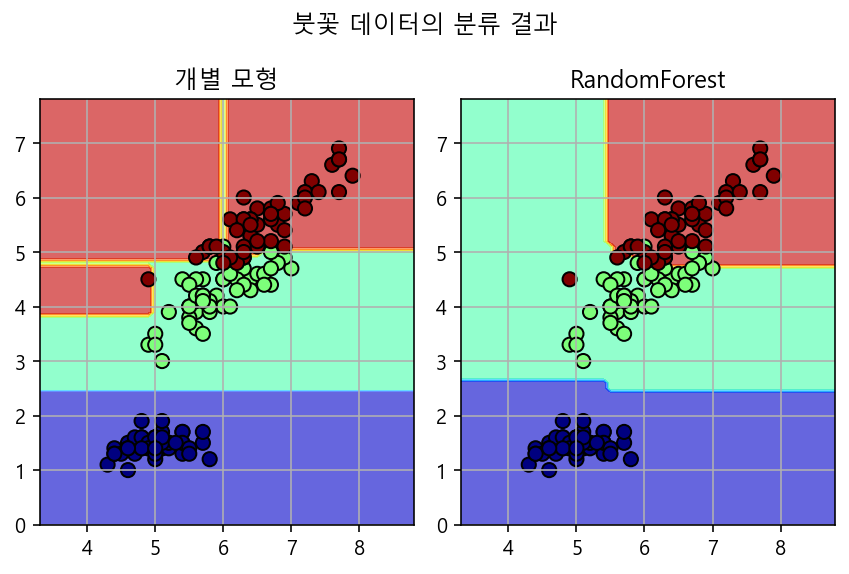

In [34]:
from sklearn.ensemble import RandomForestClassifier

model1 = DecisionTreeClassifier(max_depth=10, random_state=0).fit(X, y)
model2 = RandomForestClassifier(max_depth=2, n_estimators=100, random_state=0).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
plt.subplot(121)
Z1 = model1.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z1, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors="k")
plt.grid()
plt.title("개별 모형")
plt.subplot(122)
Z2 = model2.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z2, alpha=0.6, cmap=mpl.cm.jet)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1, s=50, cmap=mpl.cm.jet, edgecolors="k")
plt.title("RandomForest")
plt.suptitle("붓꽃 데이터의 분류 결과")
plt.tight_layout()
plt.grid()
plt.show()

## Feature Importances

RF model은 각 독립변수의 중요도를 계산할 수 있다.

RF의 모든 노드에 대해 어떤 독립변수를 사용했고 그 노드에서 얻은 IG값을 구할 수 있어 각각의 독립변수가 얻어낸 IG의 평균을 이용해 어떤 독립변수가 중요한지 비교할 수 있다.

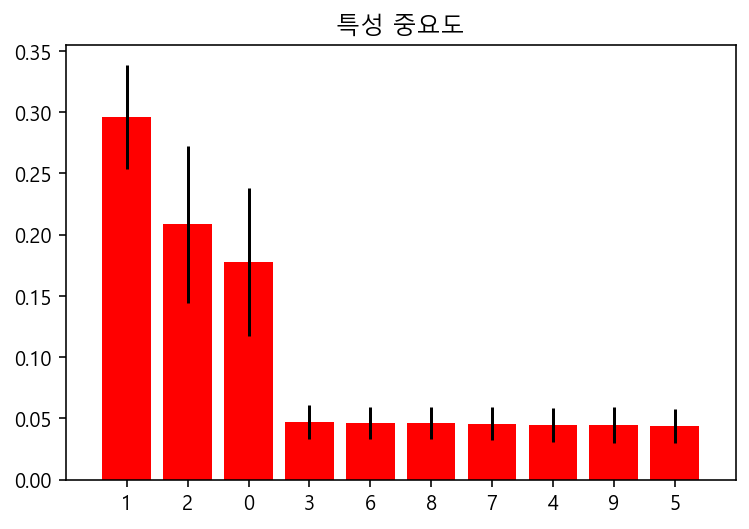

In [35]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0, n_repeated=0,
                           n_classes=2, random_state=0, shuffle=False)

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.title("특성 중요도")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## 이미지 데이터의 픽셀중요도

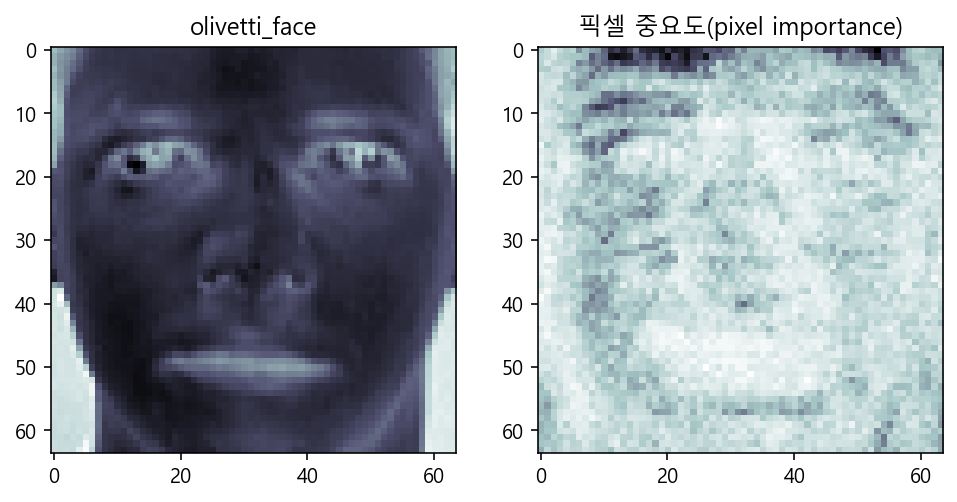

In [43]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

data = fetch_olivetti_faces()
X = data.data
y = data.target

forest = ExtraTreesClassifier(n_estimators=1000, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(data.images[0], cmap=plt.cm.bone_r)
plt.grid(False)
plt.title("olivetti_face")
plt.subplot(122)
plt.imshow(importances, cmap=plt.cm.bone_r)
plt.grid(False)
plt.title("픽셀 중요도(pixel importance)")
plt.show()

## breast cancer 데이터 Feature importances

In [44]:
# 연습문제 1

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

model1 = LogisticRegression()
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
model4 = DecisionTreeClassifier()
model = VotingClassifier(
    estimators=[('lr', model1), ('qda', model2), ('gnb', model3)], 
    voting='soft', weights=[1, 1.5, 1])

cv = KFold(5, shuffle=True, random_state=0)
accuracy = cross_val_score(model, X, y, scoring="accuracy", cv=cv)
accuracy.mean(), accuracy.std()

C:\Users\Kim\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Kim\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

(0.9683744760130415, 0.018049172540641666)

In [45]:
from sklearn.ensemble import BaggingClassifier

model1 = DecisionTreeClassifier(max_depth=5)
model2 = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100)
accuracy1 = cross_val_score(model1, X, y, scoring="accuracy", cv=cv)
accuracy2 = cross_val_score(model2, X, y, scoring="accuracy", cv=cv)
accuracy1.mean(), accuracy1.std(), accuracy2.mean(), accuracy2.std()

(0.9367489520260829,
 0.012817120404808896,
 0.9508306163639185,
 0.018003842981006796)

In [46]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=500, random_state=0).fit(X, y)
accuracy = cross_val_score(forest, X, y, scoring="accuracy", cv=cv)
accuracy.mean(), accuracy.std()

(0.9701754385964911, 0.020459480332790547)

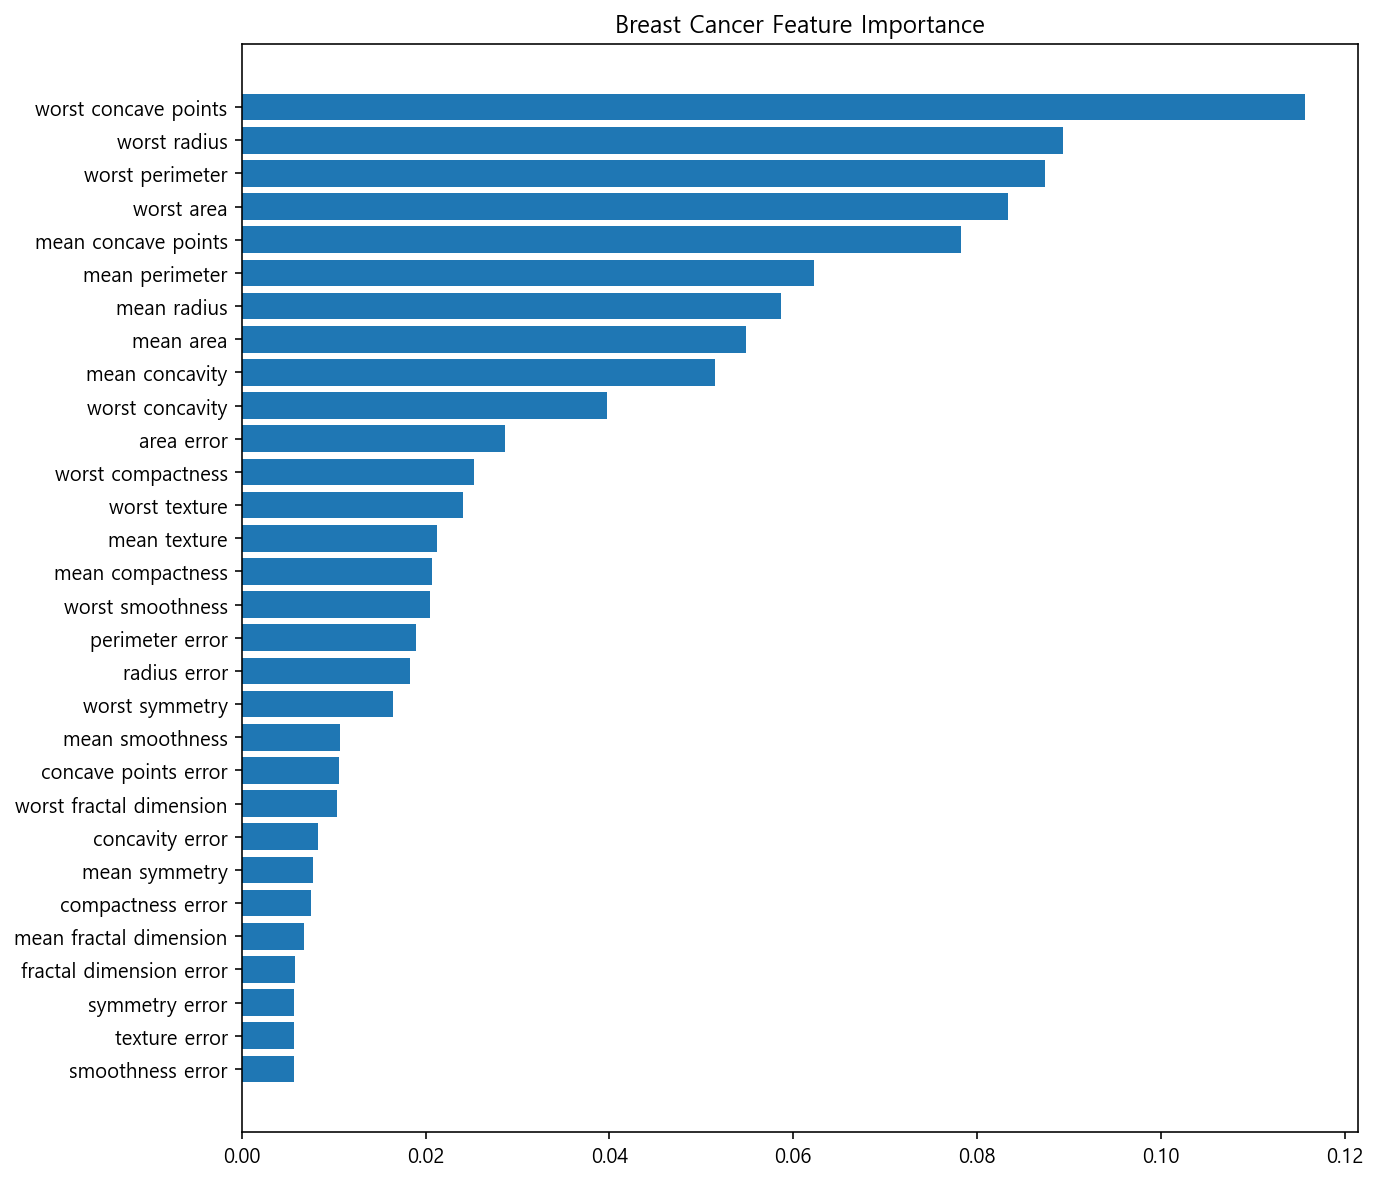

In [47]:
idx = np.argsort(forest.feature_importances_)
names = cancer.feature_names[idx]
values = forest.feature_importances_[idx]

plt.figure(figsize=(10, 10))
plt.barh(names, values)
plt.title("Breast Cancer Feature Importance")
plt.show()